# 1. Data Extraction

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
max_pause = 60 #seconds

In [3]:
pages = ["https://www.soccerstand.com/team/otoho-d-oyo/0GuF1aSS/results/",
        "https://www.soccerstand.com/team/leopard/rulf0ilK/results/",
         "https://www.soccerstand.com/team/diables-noirs/xlWrOB3I/results/",
        "https://www.soccerstand.com/team/etoile-du-congo/dISk7gAI/results/",
        "https://www.soccerstand.com/team/cara-brazzaville/AutlQkBd/results/"]

In [4]:
def get_driver(page_url):
    browser = webdriver.Chrome()
    browser.maximize_window()
    browser.get(page_url)
    
    return browser

In [5]:
def click_banner(browser):
    try:
        WebDriverWait(browser, max_pause).until(EC.presence_of_element_located(
            (By.ID, 'onetrust-accept-btn-handler'))).click()
    except Exception as E:
        print("No Banner Appeared")

In [6]:
def load_page(browser):
    #Get Current Height
    previous_height = browser.execute_script("return document.body.scrollHeight;")
    print("Current Page Height: ", previous_height)
    #Scroll down
    current_height = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    #Try clicking on the load more button
    try:
        WebDriverWait(browser, max_pause).until(EC.element_to_be_clickable(
            (By.CLASS_NAME, 'event__more--static'))).click()
    except Exception as E:
        print("No Click Made this time.") 
        return 0
    else:
        print("Clicked the button, more data Loading...")

In [7]:
def get_data(page_url):
    print(f"\nLoading Data for {page_url.split('/')[-4]}")
    driver = get_driver(page_url)
    click_banner(driver)
    
    while True:
        #Load data
        page = load_page(driver)
    
        if page == 0:
            print("Reached Bottom of the page.")
            break
        else:
            #Load more data
            load_page(driver)
    return driver.page_source

In [9]:
sources = [get_data(team) for team in pages]


Loading Data for otoho-d-oyo
Current Page Height:  3615
Clicked the button, more data Loading...
Current Page Height:  3615
No Click Made this time.
Current Page Height:  5450
Clicked the button, more data Loading...
Current Page Height:  5447
No Click Made this time.
Current Page Height:  7844
Clicked the button, more data Loading...
Current Page Height:  7844
No Click Made this time.
Current Page Height:  10138
Clicked the button, more data Loading...
Current Page Height:  10138
No Click Made this time.
Current Page Height:  11754
No Click Made this time.
Reached Bottom of the page.

Loading Data for leopard
Current Page Height:  3155
Clicked the button, more data Loading...
Current Page Height:  3155
No Click Made this time.
Current Page Height:  4988
Clicked the button, more data Loading...
Current Page Height:  4986
No Click Made this time.
Current Page Height:  6924
Clicked the button, more data Loading...
Current Page Height:  6924
No Click Made this time.
Current Page Height: 

In [10]:
soups=[BeautifulSoup(source, "html.parser") for source in sources]

In [11]:
#Save the html data for future needs
for soup in soups:
    name = soup.title.text.split()[0]
    with open(f"{name}.html", 'w') as html:
        html.write(str(soup.find("div", class_="event--leagues")))

In [12]:
def fill_df(soup_object):
    df = pd.DataFrame(
        columns=["Level", "Competition", "Team Home", "Team Away", "Score Home", "Score Away", "Event Date", "Result"])
    index = 0
    selected = False
    competitions = soup_object.find("div", class_="soccer")

    for text in competitions.find_all("div"):
        try:
            #Each text is either a competition row or a single match row
            level =text.find("span", class_="event__title--type").text
            name = text.find("span", class_="event__title--name").text
            selected = True
            
        except Exception as E1:
            if selected:
                try:
                    team_home = text.find("div", class_="event__participant--home").text
                    team_away = text.find("div", class_="event__participant--away").text
            
                    score_home = text.find("div", class_="event__score--home").text
                    score_away = text.find("div", class_="event__score--away").text
            
                    event_date = text.find("div", class_="event__time").text
                    event_result = text.find("span", class_="wld").text
                    df.loc[index] = [level, name, team_home, team_away, score_home, score_away, event_date, event_result]
                    index += 1
                    selected = False
                except Exception as E2:
                    pass
    return df

In [13]:
#Get the dataframes for each team
otoho_df = fill_df(soups[0])
leopard_df = fill_df(soups[1])
diable_df = fill_df(soups[2])
etoile_df = fill_df(soups[3])
cara_df = fill_df(soups[4])

In [14]:
otoho_df.to_csv("data_otoho_football.csv", index=False)
diable_df.to_csv("data_diable_football.csv", index=False)
etoile_df.to_csv("data_etoile_football.csv", index=False)
cara_df.to_csv("data_cara_football.csv", index=False)
leopard_df.to_csv("data_leopard_football.csv", index=False)

# 2. Data Cleaning

In [15]:
def clean_name(original):
    pattern = r"(?P<name>[\w '.\\-]+)"
    name = re.search(pattern, original)
    if name:
        name_clean = name.group('name')
        return name_clean.strip()
    else:
        return original

In [16]:
assert clean_name("A Name(With Parenthesis)") == "A Name", "Wrong Answer with Parenthesis"
assert clean_name("A Name-With Bar") == "A Name-With Bar", "Wrong Answer with Bar"

In [17]:
def clean_date(original):
    pattern1 = r"\d+\.\d+\.(?= )"
    pattern2= r"\d+\.\d+\.\d{4}(?=\w+)"
    pattern3 = r"\d+\.\d+\.\d+$"
    
    date1 = re.search(pattern1, original)
    date2= re.search(pattern2, original)
    date3 = re.search(pattern3, original)
    
    if date3:
        return original.replace('.', '/')
    elif date2:
        return date2.group(0).replace('.', '/')
    elif date1:
        replacement = date1.group(0)+"2022"
        return replacement.replace('.', '/')
    else:
        return original

In [18]:
assert clean_date("20.12. 15:17") == "20/12/2022", "Incompatible result"
assert clean_date("12.06.2014Weird") == "12/06/2014", "Extra Word not removed"
assert clean_date("9.10.2015") == "9/10/2015", "Wrong Output"

In [19]:
all_df = pd.concat([otoho_df, leopard_df, diable_df, etoile_df, cara_df], axis=0).reset_index(drop=True)

In [20]:
all_df.to_csv("Congolese_Clubs_In_Competitions.csv", index=False)

In [21]:
all_df = all_df.applymap(lambda cell:clean_name(cell))
all_df = all_df.applymap(lambda cell:clean_date(cell))
all_df["Event Date"] = pd.to_datetime(all_df["Event Date"], format="%d/%m/%Y")

In [22]:
all_df["Level"].replace({"REPUBLIC OF THE CONGO" : "Congo",
                         "AFRICA" : "Africa"}, inplace=True)

In [23]:
all_df["Year"] = all_df["Event Date"].apply(lambda x: x.year)

In [24]:
all_df.head(10)

,Level,Competition,Team Home,Team Away,Score Home,Score Away,Event Date,Result,Year
0,Congo,Ligue 1,Otoho d'Oyo,Kondzo,0,0,2022-06-12,D,2022
1,Africa,CAF Confederation Cup,Cotonsport,Otoho d'Oyo,0,1,2022-04-03,W,2022
2,Congo,Ligue 1,Otoho d'Oyo,AS BNG,3,0,2022-03-26,W,2022
3,Africa,CAF Confederation Cup,Otoho d'Oyo,Mazembe,2,2,2022-03-20,D,2022
4,Congo,Ligue 1,Otoho d'Oyo,Leopard,1,1,2022-03-04,D,2022
5,Africa,CAF Confederation Cup,Otoho d'Oyo,Al Masry,1,0,2022-02-27,W,2022
6,Congo,Ligue 1,Otoho d'Oyo,V. Club Mokanda,1,1,2022-02-18,D,2022
7,Africa,CAF Confederation Cup,Mazembe,Otoho d'Oyo,1,0,2022-02-13,L,2022
8,Congo,Ligue 1,Etoile du Congo,Otoho d'Oyo,0,1,2022-02-06,W,2022
9,Africa,CAF Confederation Cup - Qualification,Gor Mahia,Otoho d'Oyo,1,1,2021-12-05,D,2021


In [25]:
all_df.tail(10)

,Level,Competition,Team Home,Team Away,Score Home,Score Away,Event Date,Result,Year
180,Congo,Ligue 1,Poto-Poto,CARA Brazzaville,2,1,2016-10-16,L,2016
181,Congo,Ligue 1,CARA Brazzaville,Leopard,0,1,2015-05-08,L,2015
182,Africa,CAF Confederation Cup - Qualification,CARA Brazzaville,AS Togo-Port,3,3,2015-02-28,D,2015
183,Congo,Ligue 1,CARA Brazzaville,Poto-Poto,0,0,2015-02-08,D,2015
184,Congo,Ligue 1,CARA Brazzaville,Bilombe,2,0,2014-07-13,W,2014
185,Africa,CAF Confederation Cup - Qualification,Etoile Sahel,CARA Brazzaville,3,0,2014-03-07,L,2014
186,Congo,Ligue 1,Tongo FC Jambon,CARA Brazzaville,0,0,2014-03-04,D,2014
187,Africa,CAF Confederation Cup - Qualification,CARA Brazzaville,Etoile Sahel,1,0,2014-03-01,W,2014
188,Congo,Ligue 1,St-Michel Ouenze,CARA Brazzaville,1,1,2014-02-24,D,2014
189,Africa,CAF Confederation Cup - Qualification,CARA Brazzaville,Al-Malakia,4,1,2014-02-16,W,2014


# 3. Data analysis

In [26]:
import matplotlib.pyplot as plt

In [27]:
#Otoho Data Start from 2017, so let's select only data from that year
sample_df = all_df.loc[all_df["Year"]>2016, all_df.columns]

In [28]:
teams = ["CARA Brazzaville", "Otoho d'Oyo", "Leopard", "Diables Noirs", "Etoile du Congo"]

In [29]:
home = sample_df.loc[sample_df["Team Home"].isin(teams), ["Level", "Competition", "Year", "Team Home", "Result"]]
home.rename(columns={"Team Home":"Team"}, inplace=True)

In [30]:
away = sample_df.loc[sample_df["Team Away"].isin(teams), ["Level", "Competition", "Year", "Team Away", "Result"]]
away.rename(columns={"Team Away":"Team"}, inplace=True)

In [31]:
away.head()

,Level,Competition,Year,Team,Result
1,Africa,CAF Confederation Cup,2022,Otoho d'Oyo,W
4,Congo,Ligue 1,2022,Leopard,D
7,Africa,CAF Confederation Cup,2022,Otoho d'Oyo,L
8,Congo,Ligue 1,2022,Otoho d'Oyo,W
9,Africa,CAF Confederation Cup - Qualification,2021,Otoho d'Oyo,D


In [32]:
home.head()

,Level,Competition,Year,Team,Result
0,Congo,Ligue 1,2022,Otoho d'Oyo,D
2,Congo,Ligue 1,2022,Otoho d'Oyo,W
3,Africa,CAF Confederation Cup,2022,Otoho d'Oyo,D
4,Congo,Ligue 1,2022,Otoho d'Oyo,D
5,Africa,CAF Confederation Cup,2022,Otoho d'Oyo,W


In [33]:
all_results = pd.concat([home, away], axis=0).reset_index(drop=True)

In [34]:
all_results.tail()

,Level,Competition,Year,Team,Result
121,Africa,CAF Confederation Cup - Qualification,2018,CARA Brazzaville,L
122,Congo,Ligue 1,2018,CARA Brazzaville,L
123,Africa,CAF Confederation Cup - Qualification,2018,CARA Brazzaville,L
124,Congo,Ligue 1,2018,CARA Brazzaville,W
125,Congo,Ligue 1,2017,CARA Brazzaville,D


In [35]:
summary = all_results.groupby(["Team", "Year", "Result"]).size().reset_index(name="Game Count")

In [36]:
summary.head(10)

,Team,Year,Result,Game Count
0,CARA Brazzaville,2017,D,1
1,CARA Brazzaville,2017,W,2
2,CARA Brazzaville,2018,D,2
3,CARA Brazzaville,2018,L,14
4,CARA Brazzaville,2018,W,12
5,CARA Brazzaville,2019,D,1
6,CARA Brazzaville,2020,D,2
7,CARA Brazzaville,2021,D,2
8,CARA Brazzaville,2022,L,1
9,CARA Brazzaville,2022,W,1


In [37]:
summary["Total Plays"] = summary.groupby(["Team", "Year"])["Game Count"].transform('sum')
summary["Winning Percentage"] = summary["Game Count"]/summary["Total Plays"]

In [38]:
wins_summary = summary.loc[summary["Result"]=="W", ["Team", "Year", "Winning Percentage", "Total Plays"]]

In [39]:
wins_summary.head(10)

,Team,Year,Winning Percentage,Total Plays
1,CARA Brazzaville,2017,0.666667,3
4,CARA Brazzaville,2018,0.428571,28
9,CARA Brazzaville,2022,0.500000,2
11,Diables Noirs,2017,0.750000,4
15,Diables Noirs,2020,1.000000,1
18,Diables Noirs,2022,1.000000,1
20,Etoile du Congo,2017,0.600000,5
21,Etoile du Congo,2018,1.000000,1
26,Etoile du Congo,2022,0.666667,3
29,Leopard,2017,0.285714,7


In [40]:
colors = {"CARA Brazzaville":"red", "Diables Noirs":"black", "Etoile du Congo":"gold",
          "Leopard":"green", "Otoho d'Oyo":"royalblue"}

In [41]:
wins_summary["Colors"] = wins_summary["Team"].map(lambda t:colors.get(t))

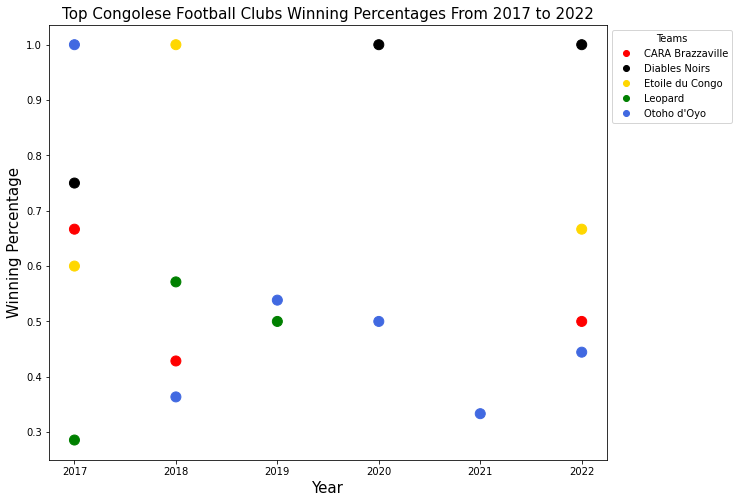

In [43]:
plt.figure(figsize=(10, 8))

year = wins_summary["Year"]
ratio = wins_summary["Winning Percentage"]
legend_colors = wins_summary["Colors"]

legendhandle = [plt.plot([], marker="o", ls="", color=col)[0] for col in colors.values()]

scatter = plt.scatter(year, ratio, s=100, c=legend_colors)
plt.xlabel("Year", size=15)
plt.ylabel("Winning Percentage", size=15)
plt.title("Top Congolese Football Clubs Winning Percentages From 2017 to 2022", size=15)
plt.legend(legendhandle, wins_summary["Team"].unique(), title="Teams", bbox_to_anchor=(1, 1))
plt.show()

# The End.